In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
def yoon_kim_conv_layer(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)
    
    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([block_1_max_pool1, block_1_max_pool2, block_1_max_pool3, block_1_max_pool4])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [9]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 256

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Add()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

features_1 = yoon_kim_conv_layer(filtersNumber, embedding_dropout)
features_2 = yoon_kim_conv_layer(filtersNumber, embedding_dropout)
features_3 = yoon_kim_conv_layer(filtersNumber, embedding_dropout)

features = concatenate([features_1, features_2, features_3])
features_dropout = Dropout(0.2)(features)

dense_1 = Dense(256, activation = 'elu')(features_dropout)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________

In [10]:
history = train_with_cv(model, batchSize=64, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 42880/102124 [===========>..................] - ETA: 5:03 - loss: 0.1597 - acc: 0.9389

102124/102124 [==============================] - 563s 6ms/step - loss: 0.1020 - acc: 0.9619 - val_loss: 0.0479 - val_acc: 0.9825
Epoch 2/32
  5440/102124 [>.............................] - ETA: 8:02 - loss: 0.0524 - acc: 0.9812

102080/102124 [============================>.] - ETA: 0s - loss: 0.0524 - acc: 0.9807

102124/102124 [==============================] - 558s 5ms/step - loss: 0.0524 - acc: 0.9807 - val_loss: 0.0446 - val_acc: 0.9835
roc-auc: 0.9869 - roc-auc_val: 0.9828                                                                                                    
Epoch 3/32
 17408/102124 [====>.........................] - ETA: 7:04 - loss: 0.0483 - acc: 0.9817

102080/102124 [============================>.] - ETA: 0s - loss: 0.0478 - acc: 0.9820

102124/102124 [==============================] - 558s 5ms/step - loss: 0.0478 - acc: 0.9820 - val_loss: 0.0421 - val_acc: 0.9837
Epoch 4/32
 20352/102124 [====>.........................] - ETA: 6:49 - loss: 0.0456 - acc: 0.9825

102080/102124 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9827

102124/102124 [==============================] - 559s 5ms/step - loss: 0.0449 - acc: 0.9827 - val_loss: 0.0421 - val_acc: 0.9843
roc-auc: 0.9921 - roc-auc_val: 0.9864                                                                                                    
Epoch 5/32
 17408/102124 [====>.........................] - ETA: 7:04 - loss: 0.0416 - acc: 0.9838

102080/102124 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9835

102124/102124 [==============================] - 558s 5ms/step - loss: 0.0425 - acc: 0.9835 - val_loss: 0.0429 - val_acc: 0.9835

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003298769879620522.
Epoch 6/32
 16064/102124 [===>..........................] - ETA: 7:11 - loss: 0.0405 - acc: 0.9841

102080/102124 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9842

102124/102124 [==============================] - 559s 5ms/step - loss: 0.0402 - acc: 0.9842 - val_loss: 0.0422 - val_acc: 0.9844
roc-auc: 0.9942 - roc-auc_val: 0.9865                                                                                                    
Epoch 7/32
 17408/102124 [====>.........................] - ETA: 7:04 - loss: 0.0385 - acc: 0.9845

102080/102124 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9849

102124/102124 [==============================] - 559s 5ms/step - loss: 0.0378 - acc: 0.9849 - val_loss: 0.0440 - val_acc: 0.9837
Epoch 8/32
 20352/102124 [====>.........................] - ETA: 6:49 - loss: 0.0358 - acc: 0.9857

102080/102124 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9858

102124/102124 [==============================] - 559s 5ms/step - loss: 0.0358 - acc: 0.9858 - val_loss: 0.0438 - val_acc: 0.9843
roc-auc: 0.9951 - roc-auc_val: 0.9855                                                                                                    
Epoch 9/32
 17408/102124 [====>.........................] - ETA: 7:04 - loss: 0.0336 - acc: 0.9863

102080/102124 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9865

102124/102124 [==============================] - 559s 5ms/step - loss: 0.0337 - acc: 0.9865 - val_loss: 0.0432 - val_acc: 0.9842
Epoch 10/32
 20288/102124 [====>.........................] - ETA: 6:50 - loss: 0.0322 - acc: 0.9867

102080/102124 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9870

102124/102124 [==============================] - 559s 5ms/step - loss: 0.0322 - acc: 0.9870 - val_loss: 0.0452 - val_acc: 0.9842
roc-auc: 0.9933 - roc-auc_val: 0.9841                                                                                                    
Epoch 11/32
 17344/102124 [====>.........................] - ETA: 7:04 - loss: 0.0295 - acc: 0.9878

102080/102124 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9876

102124/102124 [==============================] - 559s 5ms/step - loss: 0.0308 - acc: 0.9876 - val_loss: 0.0440 - val_acc: 0.9844
Epoch 12/32
 20288/102124 [====>.........................] - ETA: 6:49 - loss: 0.0290 - acc: 0.9881

102080/102124 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9880

102124/102124 [==============================] - 559s 5ms/step - loss: 0.0295 - acc: 0.9880 - val_loss: 0.0456 - val_acc: 0.9840
roc-auc: 0.994 - roc-auc_val: 0.9842                                                                                                    
Epoch 13/32
 17408/102124 [====>.........................] - ETA: 7:04 - loss: 0.0274 - acc: 0.9889

102080/102124 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9885

102124/102124 [==============================] - 558s 5ms/step - loss: 0.0280 - acc: 0.9885 - val_loss: 0.0467 - val_acc: 0.9843
Epoch 14/32
 20288/102124 [====>.........................] - ETA: 6:50 - loss: 0.0254 - acc: 0.9895

102080/102124 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9891

102124/102124 [==============================] - 558s 5ms/step - loss: 0.0266 - acc: 0.9891 - val_loss: 0.0469 - val_acc: 0.9842
roc-auc: 0.9978 - roc-auc_val: 0.986                                                                                                    




```
# It seems like model is best to fit in the interval of 8 to 12 epochs.

```



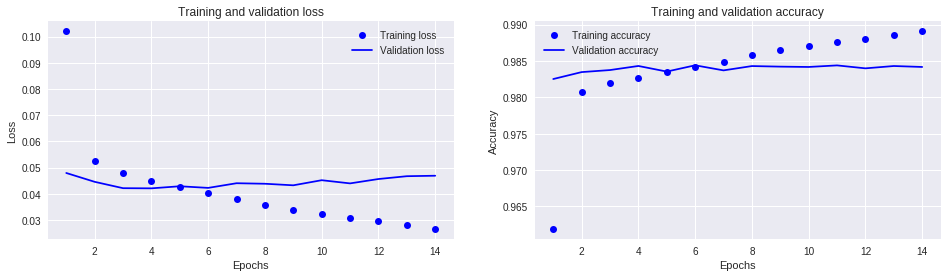

In [11]:
plot_history(history)

In [12]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 68s 2ms/step
([0.04407647187304985, 0.9846832603136798], 0.9891299144372597)


In [10]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21408/102124 [=====>........................] - ETA: 7:45 - loss: 0.1743 - acc: 0.9336

102112/102124 [============================>.] - ETA: 0s - loss: 0.0843 - acc: 0.9691

102124/102124 [==============================] - 625s 6ms/step - loss: 0.0843 - acc: 0.9691 - val_loss: 0.0487 - val_acc: 0.9824
Epoch 2/32
 14048/102124 [===>..........................] - ETA: 8:11 - loss: 0.0529 - acc: 0.9801

102112/102124 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9808

102124/102124 [==============================] - 621s 6ms/step - loss: 0.0518 - acc: 0.9808 - val_loss: 0.0460 - val_acc: 0.9824
roc-auc: 0.9879 - roc-auc_val: 0.9844                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 8:40 - loss: 0.0496 - acc: 0.9809

102112/102124 [============================>.] - ETA: 0s - loss: 0.0478 - acc: 0.9817

102124/102124 [==============================] - 622s 6ms/step - loss: 0.0478 - acc: 0.9817 - val_loss: 0.0436 - val_acc: 0.9839
Epoch 4/32
 14048/102124 [===>..........................] - ETA: 8:12 - loss: 0.0449 - acc: 0.9826

102112/102124 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9827

102124/102124 [==============================] - 622s 6ms/step - loss: 0.0449 - acc: 0.9827 - val_loss: 0.0414 - val_acc: 0.9843
roc-auc: 0.9906 - roc-auc_val: 0.9873                                                                                                    
Epoch 5/32
  8736/102124 [=>............................] - ETA: 8:39 - loss: 0.0416 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9833

102124/102124 [==============================] - 621s 6ms/step - loss: 0.0423 - acc: 0.9833 - val_loss: 0.0424 - val_acc: 0.9843
Epoch 6/32
 14048/102124 [===>..........................] - ETA: 8:09 - loss: 0.0395 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9842

102124/102124 [==============================] - 622s 6ms/step - loss: 0.0397 - acc: 0.9842 - val_loss: 0.0426 - val_acc: 0.9843

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00029730176902376115.
roc-auc: 0.9916 - roc-auc_val: 0.9856                                                                                                    
Epoch 7/32
  5952/102124 [>.............................] - ETA: 8:57 - loss: 0.0383 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9852

102124/102124 [==============================] - 621s 6ms/step - loss: 0.0372 - acc: 0.9852 - val_loss: 0.0422 - val_acc: 0.9843
Epoch 8/32
 14048/102124 [===>..........................] - ETA: 8:12 - loss: 0.0360 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9856

102124/102124 [==============================] - 623s 6ms/step - loss: 0.0355 - acc: 0.9856 - val_loss: 0.0477 - val_acc: 0.9837
roc-auc: 0.9945 - roc-auc_val: 0.9867                                                                                                    
Epoch 9/32
  8736/102124 [=>............................] - ETA: 8:42 - loss: 0.0348 - acc: 0.9857

102112/102124 [============================>.] - ETA: 0s - loss: 0.0334 - acc: 0.9865

102124/102124 [==============================] - 622s 6ms/step - loss: 0.0334 - acc: 0.9865 - val_loss: 0.0510 - val_acc: 0.9840
Epoch 10/32
 13984/102124 [===>..........................] - ETA: 8:11 - loss: 0.0319 - acc: 0.9873

102112/102124 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9872

102124/102124 [==============================] - 621s 6ms/step - loss: 0.0319 - acc: 0.9872 - val_loss: 0.0494 - val_acc: 0.9842
roc-auc: 0.9944 - roc-auc_val: 0.9847                                                                                                    
Epoch 11/32
  8704/102124 [=>............................] - ETA: 8:42 - loss: 0.0288 - acc: 0.9883

102112/102124 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9876

102124/102124 [==============================] - 622s 6ms/step - loss: 0.0301 - acc: 0.9876 - val_loss: 0.0455 - val_acc: 0.9842
Epoch 12/32
 13984/102124 [===>..........................] - ETA: 8:10 - loss: 0.0289 - acc: 0.9882

102112/102124 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9882

102124/102124 [==============================] - 622s 6ms/step - loss: 0.0289 - acc: 0.9882 - val_loss: 0.0478 - val_acc: 0.9841
roc-auc: 0.9949 - roc-auc_val: 0.9869                                                                                                    
Epoch 13/32
  8704/102124 [=>............................] - ETA: 8:42 - loss: 0.0288 - acc: 0.9882

102112/102124 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9889

102124/102124 [==============================] - 621s 6ms/step - loss: 0.0276 - acc: 0.9889 - val_loss: 0.0492 - val_acc: 0.9841
Epoch 14/32
 13984/102124 [===>..........................] - ETA: 8:12 - loss: 0.0267 - acc: 0.9893

102112/102124 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9893

102124/102124 [==============================] - 622s 6ms/step - loss: 0.0265 - acc: 0.9893 - val_loss: 0.0530 - val_acc: 0.9839
roc-auc: 0.9956 - roc-auc_val: 0.9859                                                                                                    


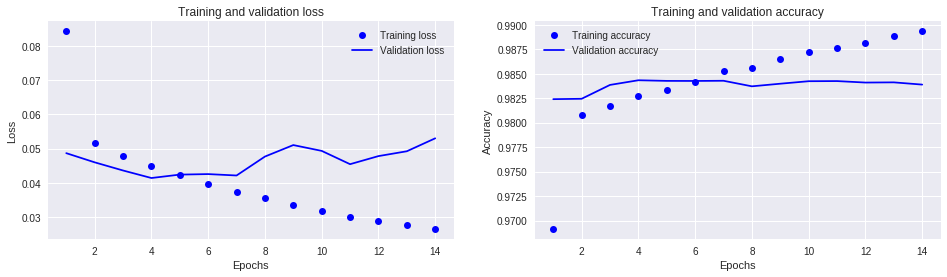

In [11]:
plot_history(history)

In [12]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 68s 2ms/step
([0.04967320623805366, 0.9843803718268227], 0.9852016011144311)
